# 🧠 Análisis de la Readmisión a la UCI en Pacientes con Hemorragia Intracerebral (MIMIC-IV)

## 1. 🔧 Configuración Inicial

In [90]:
%reset -f


from google.cloud import bigquery
from google.oauth2 import service_account

# Path to your service account key file
SERVICE_ACCOUNT_FILE = "mimic-sergi.json"
PROJECT_ID = "ogi-uci-i61"

# Create credentials and client
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE)

client = bigquery.Client(credentials=credentials, project=PROJECT_ID)

# Example query
query = "SELECT 'Hello, World!' AS greeting"
query_job = client.query(query)

# Fetch results
results = query_job.result()

for row in results:
    print(row.greeting)

Hello, World!


## 2. 📦 Extracción de Datos

In [98]:
## Export ICU ICH Cohort from MIMIC-IV to CSV

## SQL query
query = """
WITH ich_admissions AS (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i
  WHERE (i.icd_version = 9 AND i.icd_code = '431')
     OR (i.icd_version = 10 AND i.icd_code IN ('I610','I611','I612','I613','I614','I615','I616','I618','I619'))
),

chartevents_avg AS (
  SELECT
    c.stay_id,
    AVG(CASE WHEN itemid = 220045 AND valuenum > 0 THEN valuenum END) AS heart_rate_avg,
    AVG(CASE WHEN itemid = 220052 AND valuenum BETWEEN 30 AND 200 THEN valuenum END) AS mbp_avg,
    AVG(CASE WHEN itemid = 220210 AND valuenum BETWEEN 5 AND 60 THEN valuenum END) AS resp_rate_avg,
    AVG(CASE WHEN itemid = 220277 AND valuenum BETWEEN 70 AND 100 THEN valuenum END) AS spo2_avg,
    AVG(CASE WHEN itemid = 220602 AND valuenum IS NOT NULL THEN valuenum END) AS chloride_avg,
    AVG(CASE WHEN itemid = 220615 AND valuenum IS NOT NULL THEN valuenum END) AS creatinine_avg,
    AVG(CASE WHEN itemid = 220645 AND valuenum IS NOT NULL THEN valuenum END) AS sodium_avg
  FROM `ogi-uci-i61.mimiciv_icu.chartevents` c
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` i ON c.stay_id = i.stay_id
  WHERE c.itemid IN (220045, 220052, 220210, 220277, 220602, 220615, 220645)
    AND c.valuenum IS NOT NULL
    AND c.charttime BETWEEN i.intime AND i.outtime
  GROUP BY c.stay_id
),

cbc_labs AS (
  SELECT
    subject_id,
    hadm_id,
    AVG(wbc) AS wbc_avg,
    MIN(hemoglobin) AS hgb_min
  FROM `ogi-uci-i61.mimiciv_derived.complete_blood_count`
  GROUP BY subject_id, hadm_id
),

chem_labs AS (
  SELECT
    subject_id,
    hadm_id,
    AVG(glucose) AS glucose_avg
  FROM `ogi-uci-i61.mimiciv_derived.chemistry`
  GROUP BY subject_id, hadm_id
),

coag_labs AS (
  SELECT
    subject_id,
    hadm_id,
    MAX(inr) AS inr_max,
    MAX(pt) AS pt_max
  FROM `ogi-uci-i61.mimiciv_derived.coagulation`
  GROUP BY subject_id, hadm_id
),

labevents AS (
  SELECT
    subject_id,
    hadm_id,
    AVG(CASE WHEN itemid = 51249 THEN valuenum END) AS mchc_avg,
    AVG(CASE WHEN itemid = 51254 THEN valuenum END) AS monocytes_avg,
    AVG(CASE WHEN itemid = 51256 THEN valuenum END) AS neutrophils_avg,
    AVG(CASE WHEN itemid = 50861 THEN valuenum END) AS alt_avg
  FROM `ogi-uci-i61.mimiciv_hosp.labevents`
  WHERE itemid IN (51249, 51254, 51256, 50861) AND valuenum IS NOT NULL
  GROUP BY subject_id, hadm_id
),

icu_stay_counts AS (
  SELECT
    hadm_id,
    COUNT(*) AS icu_stays_in_admission
  FROM `ogi-uci-i61.mimiciv_icu.icustays`
  GROUP BY hadm_id
)

SELECT
  a.subject_id,
  a.hadm_id,
  a.stay_id,
  p.gender,
  p.anchor_age AS age,
  a.intime,
  a.outtime,
  a.first_careunit,
  TIMESTAMP_DIFF(a.outtime, a.intime, HOUR) AS icu_los_hours,
  TIMESTAMP_DIFF(adm.dischtime, adm.admittime, HOUR) AS hosp_los_hours,
  adm.discharge_location,
  adm.hospital_expire_flag,

  STRING_AGG(CASE WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN i.icd_code END, '; ') AS ich_icd_codes,
  STRING_AGG(CASE
               WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN CONCAT(i.icd_code, ': ', d.long_title)
               ELSE i.icd_code
             END, '; ') AS all_diagnoses,

  s.gcs_verbal,
  s.gcs_motor,
  s.gcs_eyes,

  ce.heart_rate_avg,
  ce.mbp_avg,
  ce.resp_rate_avg,
  ce.spo2_avg,
  ce.chloride_avg,
  ce.creatinine_avg,
  ce.sodium_avg,

  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  cbc.wbc_avg,
  cbc.hgb_min,
  chem.glucose_avg,
  coag.inr_max,
  coag.pt_max,
  lab.mchc_avg,
  lab.monocytes_avg,
  lab.neutrophils_avg,
  lab.alt_avg,

  CASE WHEN hyper.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hypertension,
  CASE WHEN hydro.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hydrocephalus,
  CASE WHEN cad.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_cad,
  CASE WHEN anticoag.subject_id IS NOT NULL THEN 1 ELSE 0 END AS has_anticoagulation,
  CASE WHEN neuroproc.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS had_neurosurgery,
  CASE WHEN addmeds.subject_id IS NOT NULL THEN 1 ELSE 0 END AS on_statins_or_antiplatelets,

  icucount.icu_stays_in_admission,
  CASE WHEN icucount.icu_stays_in_admission > 1 THEN 1 ELSE 0 END AS readmitted_within_hospital_stay,

  readmit.readmitted_stay

FROM `ogi-uci-i61.mimiciv_icu.icustays` a
JOIN `ogi-uci-i61.mimiciv_hosp.patients` p ON a.subject_id = p.subject_id
JOIN `ogi-uci-i61.mimiciv_hosp.admissions` adm ON a.hadm_id = adm.hadm_id
JOIN ich_admissions ich ON a.hadm_id = ich.hadm_id

LEFT JOIN `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i ON a.hadm_id = i.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version

LEFT JOIN (
  SELECT
    stay_id,
    gcs_verbal,
    gcs_motor,
    gcs_eyes,
    ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM `ogi-uci-i61.mimiciv_derived.gcs`
) s ON a.stay_id = s.stay_id AND s.rn = 1

LEFT JOIN chartevents_avg ce ON a.stay_id = ce.stay_id

LEFT JOIN (
  SELECT
    a1.subject_id,
    a1.stay_id,
    MIN(a2.stay_id) AS readmitted_stay
  FROM `ogi-uci-i61.mimiciv_icu.icustays` a1
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` a2
    ON a1.subject_id = a2.subject_id AND a2.intime > a1.outtime AND a1.hadm_id != a2.hadm_id
  GROUP BY a1.subject_id, a1.stay_id
) readmit ON a.subject_id = readmit.subject_id AND a.stay_id = readmit.stay_id

LEFT JOIN `ogi-uci-i61.mimiciv_derived.charlson` charlson ON a.hadm_id = charlson.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_derived.apsiii` apsi ON a.stay_id = apsi.stay_id
LEFT JOIN cbc_labs cbc ON a.subject_id = cbc.subject_id AND a.hadm_id = cbc.hadm_id
LEFT JOIN chem_labs chem ON a.subject_id = chem.subject_id AND a.hadm_id = chem.hadm_id
LEFT JOIN coag_labs coag ON a.subject_id = coag.subject_id AND a.hadm_id = coag.hadm_id
LEFT JOIN labevents lab ON a.subject_id = lab.subject_id AND a.hadm_id = lab.hadm_id
LEFT JOIN icu_stay_counts icucount ON a.hadm_id = icucount.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '401%' OR icd_code LIKE 'I10%'
) hyper ON a.hadm_id = hyper.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '331.3' OR icd_code LIKE 'G91%'
) hydro ON a.hadm_id = hydro.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '414%' OR icd_code LIKE 'I25%'
) cad ON a.hadm_id = cad.hadm_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(warfarin|heparin|apixaban|rivaroxaban|dabigatran)')
    AND drug_type = 'MAIN'
) anticoag ON a.subject_id = anticoag.subject_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(aspirin|clopidogrel|atorvastatin|rosuvastatin)')
    AND drug_type = 'MAIN'
) addmeds ON a.subject_id = addmeds.subject_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.procedures_icd`
  WHERE icd_code LIKE '01%' OR icd_code LIKE '02%'
) neuroproc ON a.hadm_id = neuroproc.hadm_id

GROUP BY
  a.subject_id, a.hadm_id, a.stay_id, a.intime, a.outtime, a.first_careunit,
  p.gender, p.anchor_age,
  adm.admittime, adm.dischtime, adm.discharge_location, adm.hospital_expire_flag,
  s.gcs_verbal, s.gcs_motor, s.gcs_eyes,
  ce.heart_rate_avg, ce.mbp_avg, ce.resp_rate_avg, ce.spo2_avg, ce.chloride_avg, ce.creatinine_avg, ce.sodium_avg,
  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  cbc.wbc_avg, cbc.hgb_min,
  chem.glucose_avg,
  coag.inr_max, coag.pt_max,
  lab.mchc_avg, lab.monocytes_avg, lab.neutrophils_avg, lab.alt_avg,
  hyper.hadm_id, hydro.hadm_id, cad.hadm_id,
  anticoag.subject_id, addmeds.subject_id, neuroproc.hadm_id,
  icucount.icu_stays_in_admission,
  readmit.readmitted_stay
"""

# Execute Query and Export to CSV
df = client.query(query).to_dataframe()
df.to_csv("data/mimiciv_ich_readmission_raw.csv", index=False)
print("✅ Exported to mimiciv_ich_readmission_raw.csv")

df


✅ Exported to mimiciv_ich_readmission_raw.csv


,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,alt_avg,has_hypertension,has_hydrocephalus,has_cad,has_anticoagulation,had_neurosurgery,on_statins_or_antiplatelets,icu_stays_in_admission,readmitted_within_hospital_stay,readmitted_stay
0,11175776,25255634,35584477,M,62,2129-01-19 15:41:58,2129-01-26 07:08:35,Surgical Intensive Care Unit (SICU),160,159,...,NaN,0,0,0,1,1,0,1,0,<NA>
1,13161985,24548811,38788627,F,82,2116-06-02 02:50:00,2116-06-02 20:55:33,Trauma SICU (TSICU),18,18,...,NaN,1,1,1,1,0,1,1,0,<NA>
2,14284282,27231018,38954157,M,53,2124-05-19 22:46:00,2124-05-21 17:03:12,Trauma SICU (TSICU),43,42,...,24.333333,1,0,0,0,1,0,1,0,<NA>
3,14378301,27614697,30207471,F,42,2169-12-15 21:46:35,2169-12-16 15:41:17,Neuro Stepdown,18,231,...,17.500000,0,0,0,1,0,0,1,0,<NA>
4,10763729,25978404,36052003,M,49,2181-11-22 00:59:00,2181-12-07 17:27:23,Trauma SICU (TSICU),377,1165,...,48.800000,0,0,0,1,1,0,2,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3616,13495200,29364600,34736434,M,50,2160-12-11 01:49:21,2161-01-14 14:47:44,Neuro Intermediate,829,853,...,26.000000,1,0,0,1,1,0,1,0,<NA>
3617,11580826,20361719,36121259,M,62,2141-02-12 17:10:54,2141-02-14 17:52:36,Neuro Surgical Intensive Care Unit (Neuro SICU),48,261,...,21.000000,1,0,0,1,0,0,1,0,<NA>
3618,10056176,29428754,33139006,M,47,2160-06-19 22:53:00,2160-06-20 17:53:16,Neuro Intermediate,19,20,...,NaN,1,0,0,1,0,0,1,0,<NA>
3619,13028992,21988559,39203202,M,69,2110-10-25 19:16:47,2110-10-27 11:26:51,Medical Intensive Care Unit (MICU),40,166,...,53.000000,0,0,0,1,1,1,1,0,<NA>


## 📊 Consulta SQL para analizar pacientes con Hemorragia Intracerebral (ICH) en MIMIC-IV

Esta consulta está diseñada para extraer una cohorte de pacientes con **hemorragia intracerebral (ICH)** ingresados en la UCI, utilizando datos del conjunto **MIMIC-IV**. Además, incluye variables clínicas, de laboratorio y de resultados, así como etiquetas útiles para estudios de readmisión.

---

### 🔍 1. Selección de Pacientes con Diagnóstico de ICH
Se seleccionan pacientes con códigos ICD-9 ('431') o ICD-10 ('I610' a 'I619') correspondientes a hemorragia intracerebral:

```sql
WITH ich_admissions AS (
  SELECT DISTINCT hadm_id
  FROM diagnoses_icd
  WHERE icd_code en lista de ICH
)
```

---

### 🏥 2. Extracción de Datos Clínicos de la UCI
Se extraen valores promedio o extremos de:
- Signos vitales: frecuencia cardíaca, presión arterial media, frecuencia respiratoria, saturación de oxígeno.
- Resultados de laboratorio: hemoglobina, glucosa, creatinina, cloruro, sodio, entre otros.
- Escalas clínicas: Glasgow Coma Scale (GCS), APS-III.
- Índice de comorbilidad de Charlson.

---

### 🧪 3. Diagnósticos, Tratamientos y Procedimientos
Se identifican condiciones y tratamientos relevantes:
- Diagnósticos: hipertensión, hidrocefalia, enfermedad coronaria.
- Medicación: anticoagulantes, estatinas, antiplaquetarios.
- Procedimientos: neurocirugía.

---

### 🔁 4. Conteo de Estancias en UCI por Admisión Hospitalaria
Se calcula cuántas veces un paciente ingresó a la UCI durante una misma hospitalización (`hadm_id`):

```sql
icu_stay_counts AS (
  SELECT hadm_id, COUNT(*) AS icu_stays_in_admission
  FROM icustays
  GROUP BY hadm_id
)
```

Esto permite detectar readmisiones intrahospitalarias a la UCI, que son relevantes para evaluar estabilidad clínica.

---

### 🚨 5. Identificación de Readmisión a la UCI en Otra Hospitalización
Se detecta si el paciente fue readmitido a la UCI **después del alta actual**, pero solo si ocurrió en una hospitalización diferente:

```sql
JOIN icustays a1
JOIN icustays a2
ON mismo subject_id
AND a2.intime > a1.outtime
AND a2.hadm_id != a1.hadm_id
```

Esto evita contar transferencias internas como nuevas readmisiones.

---

### 🟢 6. Etiquetas Derivadas Finales
- `readmitted_stay`: indica si hubo una futura estancia en UCI tras el alta actual (en otra hospitalización).
- `icu_stays_in_admission`: número total de estancias en UCI durante el mismo `hadm_id`.
- `readmitted_within_hospital_stay`: indicador binario (1/0) si el paciente volvió a la UCI en la misma hospitalización.

---

### 📁 7. Exportación del Resultado
El DataFrame resultante puede exportarse como CSV para análisis posteriores:

```python
df.to_csv("data/mimiciv_ich_readmission_raw.csv", index=False)
```

---

### ✅ Utilidad
Esta consulta es ideal para:
- Modelos de predicción de readmisión a la UCI.
- Evaluación de complicaciones clínicas post-ICH.
- Estudios sobre uso de recursos críticos en el entorno hospitalario.


In [99]:

# Display the columns of the DataFrame

print(df.columns)

Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'age', 'intime',
       'outtime', 'first_careunit', 'icu_los_hours', 'hosp_los_hours',
       'discharge_location', 'hospital_expire_flag', 'ich_icd_codes',
       'all_diagnoses', 'gcs_verbal', 'gcs_motor', 'gcs_eyes',
       'heart_rate_avg', 'mbp_avg', 'resp_rate_avg', 'spo2_avg',
       'chloride_avg', 'creatinine_avg', 'sodium_avg',
       'charlson_comorbidity_index', 'apsiii', 'wbc_avg', 'hgb_min',
       'glucose_avg', 'inr_max', 'pt_max', 'mchc_avg', 'monocytes_avg',
       'neutrophils_avg', 'alt_avg', 'has_hypertension', 'has_hydrocephalus',
       'has_cad', 'has_anticoagulation', 'had_neurosurgery',
       'on_statins_or_antiplatelets', 'icu_stays_in_admission',
       'readmitted_within_hospital_stay', 'readmitted_stay'],
      dtype='object')


## 3. 🧽 Preprocesamiento



## 🧹 Limpieza del Conjunto de Datos de Pacientes con ICH

Este script de Python realiza una serie de pasos para limpiar y preparar el conjunto de datos de pacientes con hemorragia intracerebral (ICH) ingresados en la UCI, antes de entrenar modelos o realizar análisis clínicos.

---

### 📌 Pasos de Limpieza

1. **Eliminar pacientes fallecidos en el hospital**
   - Se excluyen todos los registros donde `hospital_expire_flag == 1`.

2. **Eliminar pacientes con alta hospitalaria registrada como 'DIED'**
   - Se filtran registros donde la columna `discharge_location` sea distinta de `'DIED'`.

3. **Eliminar estancias en UCI menores a 24 horas**
   - Se convierte `icu_los_hours` a numérico y se filtran los casos con valor menor a 24.

4. **Eliminar pacientes menores de 18 años**
   - Solo se consideran adultos (`age >= 18`).

5. **Eliminar registros con duración de hospitalización negativa**
   - Se asegura que `hosp_los_hours >= 0`. Valores negativos son inconsistencias que pueden provenir de errores en el registro.

6. **Eliminar filas con valores nulos en columnas categóricas**
   - Se identifican automáticamente todas las columnas de tipo `object` o `category`, y se eliminan filas que contengan `NaN` en ellas. Esto asegura que las variables categóricas estén limpias para codificación o análisis posterior.

---

### 🎯 Creación de Variable Objetivo: `readmitted`
- Se crea una columna binaria `readmitted`, que toma el valor `1` si `readmitted_stay` no es nulo (es decir, hubo una readmisión a UCI en otra hospitalización), y `0` en caso contrario.

---

### 🆔 Verificación de IDs
- Se comprueba que `stay_id` y `hadm_id` sean únicos (sin duplicados).
- Si hay duplicados en `stay_id`, se imprime un ejemplo y se identifican las columnas que difieren para inspección manual.

---

### ✅ Resultado Final
Después de estos pasos, se obtiene un conjunto de datos más limpio, confiable y listo para análisis predictivos o estadísticos, minimizando el ruido por errores de entrada o inconsistencias clínicas.

In [100]:
import pandas as pd
import numpy as np

df= pd.read_csv("data/mimiciv_ich_readmission_raw.csv")
print(f"✅ Archivo cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

# Remove patients who died in the hospital
df = df[df['hospital_expire_flag'] == 0]
print(f"Remaining patients after removing in-hospital deaths: {len(df)}")

# Remove rows where discharge location is 'DIED'
if 'discharge_location' in df.columns:
    df = df[df['discharge_location'].str.upper() != 'DIED']

# Remove patients who spent less than 24 hours in ICU
df['icu_los_hours'] = pd.to_numeric(df['icu_los_hours'], errors='coerce')
df = df[df['icu_los_hours'] >= 24]
print(f"Remaining patients after filtering ICU stays < 24 hrs: {len(df)}")

# Remove patients under 18 years old
df = df[df['age'] >= 18]
print(f"Remaining patients after filtering patients under 18: {len(df)}")

# Remove rows with negative hospital length of stay
df['hosp_los_hours'] = pd.to_numeric(df['hosp_los_hours'], errors='coerce')
df = df[df['hosp_los_hours'] >= 0]
print(f"Remaining patients after removing negative hospital LOS: {len(df)}")

# Drop rows with NA in categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df = df.dropna(subset=categorical_cols)
print(f"Remaining patients after dropping NA in categorical columns: {len(df)}")

# Create target variable
print("\nNulls in readmitted_stay before fillna:", df['readmitted_stay'].isnull().sum())
df['readmitted'] = df['readmitted_stay'].notnull().astype(int)
print("Class distribution in readmitted:", df['readmitted'].value_counts())

# Check ID uniqueness
print(f"\nUnique stay IDs: {df['stay_id'].nunique()}")
print(f"Duplicate stay IDs: {df.duplicated(subset='stay_id').sum()}")
print(f"Unique hadm IDs: {df['hadm_id'].nunique()}")
print(f"Duplicate hadm IDs: {df.duplicated(subset='hadm_id').sum()}")

# Inspect an example if duplicates exist
duplicated_ids = df['stay_id'].value_counts()
if (dupes := duplicated_ids[duplicated_ids > 1]).any():
    sample = dupes.index[0]
    print(f"\nInspecting duplicate stay_id: {sample}")
    differing = df[df['stay_id'] == sample].nunique().loc[lambda x: x > 1].index.tolist()
    print(f"Differing columns: {differing}")
else:
    print("No duplicated stay IDs found.")

df

✅ Archivo cargado: 3621 filas, 44 columnas
Remaining patients after removing in-hospital deaths: 2771
Remaining patients after filtering ICU stays < 24 hrs: 2450
Remaining patients after filtering patients under 18: 2450
Remaining patients after removing negative hospital LOS: 2450
Remaining patients after dropping NA in categorical columns: 2446

Nulls in readmitted_stay before fillna: 1991
Class distribution in readmitted: readmitted
0    1991
1     455
Name: count, dtype: int64

Unique stay IDs: 2446
Duplicate stay IDs: 0
Unique hadm IDs: 2199
Duplicate hadm IDs: 247
No duplicated stay IDs found.


,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,has_hypertension,has_hydrocephalus,has_cad,has_anticoagulation,had_neurosurgery,on_statins_or_antiplatelets,icu_stays_in_admission,readmitted_within_hospital_stay,readmitted_stay,readmitted
4,10763729,25978404,36052003,M,49,2181-11-22 00:59:00,2181-12-07 17:27:23,Trauma SICU (TSICU),377.0,1165,...,0,0,0,1,1,0,2,1,NaN,0
5,15731080,28510546,31121575,F,71,2148-01-09 21:12:00,2148-01-17 17:02:10,Neuro Intermediate,188.0,237,...,1,0,0,1,0,0,1,0,NaN,0
7,16799689,20588085,36589662,M,63,2166-02-09 19:02:00,2166-02-15 12:26:50,Neuro Intermediate,137.0,139,...,1,0,0,1,0,1,1,0,33734563.0,1
9,16335402,23168312,37683708,F,73,2120-03-20 16:59:51,2120-03-25 19:00:26,Neuro Intermediate,123.0,122,...,0,0,0,1,0,1,1,0,NaN,0
10,10099497,27666080,30351720,M,78,2145-02-27 02:11:00,2145-02-28 16:17:24,Surgical Intensive Care Unit (SICU),38.0,107,...,1,0,1,1,0,1,1,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,19337137,20086418,36377368,F,65,2124-02-19 16:41:59,2124-02-20 23:02:21,Surgical Intensive Care Unit (SICU),31.0,296,...,1,0,0,1,1,1,2,1,NaN,0
3616,13495200,29364600,34736434,M,50,2160-12-11 01:49:21,2161-01-14 14:47:44,Neuro Intermediate,829.0,853,...,1,0,0,1,1,0,1,0,NaN,0
3617,11580826,20361719,36121259,M,62,2141-02-12 17:10:54,2141-02-14 17:52:36,Neuro Surgical Intensive Care Unit (Neuro SICU),48.0,261,...,1,0,0,1,0,0,1,0,NaN,0
3619,13028992,21988559,39203202,M,69,2110-10-25 19:16:47,2110-10-27 11:26:51,Medical Intensive Care Unit (MICU),40.0,166,...,0,0,0,1,1,1,1,0,NaN,0


Este bloque de código realiza las siguientes tareas clave:

1. **Conversión de tipos de datos**:
   - Convierte `icu_los_hours` a tipo numérico.
   - Cambia `gcs_verbal`, `gcs_motor`, `gcs_eyes` y `gender` a tipo categórico para facilitar análisis y codificación.

2. **Codificación one-hot de variables categóricas**:
   - Se define una función `clean_and_encode_all_categories` que:
     - Limpia los valores (mayúsculas, sin espacios, reemplaza nulos).
     - Genera variables dummy (una columna binaria por categoría).
     - Elimina la columna original.

3. **Aplicación de la función**:
   - Se codifican completamente las columnas `first_careunit` y `discharge_location` usando one-hot encoding con prefijos `icu_` y `dispo_`.

Esto permite que las variables categóricas estén listas para ser utilizadas en modelos predictivos.

### 🎯 Feature Selection from ICD Diagnoses via Statistical Association with Readmission
This section processes the ALL_DIAGNOSES column, extracting individual ICD codes, then runs chi-squared tests to find those significantly associated with ICU readmission.

Only those codes with adjusted p-value < 0.05 are retained as binary features. This reduces dimensionality and improves model interpretability.

In [101]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests

# Step 1: Extract individual ICD codes
df['icd_codes'] = df['all_diagnoses'].fillna('').apply(
    lambda s: [x.strip().split(':')[0] for x in s.split(';') if x.strip()]
)

# Step 2: One-hot encode all ICD codes
mlb = MultiLabelBinarizer(sparse_output=False)
icd_df = pd.DataFrame(mlb.fit_transform(df['icd_codes']), columns=mlb.classes_)
icd_df.index = df.index  # ensure alignment

# Step 3: Run chi-squared test for each code vs readmission
pvals = []
target = 'readmitted_within_hospital_stay'

for col in icd_df.columns:
    contingency = pd.crosstab(icd_df[col], df[target])
    if contingency.shape == (2, 2):  # skip if not enough data
        _, p, _, _ = chi2_contingency(contingency)
        pvals.append((col, p))

# --- Settings ---
TOP_N_ICD_CODES = 50  # 👈 Change this value to use top N ICD codes

# Step 4: Adjust for multiple testing
import pandas as pd  # if not already imported
from statsmodels.stats.multitest import multipletests

results_df = pd.DataFrame(pvals, columns=['icd_code', 'pval'])

# Total number of tests (m)
m = len(results_df)

# Apply Benjamini-Hochberg (FDR)
adjusted_pvals = multipletests(results_df['pval'], method='fdr_bh')[1]
results_df['adj_pval'] = adjusted_pvals

# Add rank and sort
results_df['rank_i'] = results_df['pval'].rank(method='min').astype(int)
results_df['m'] = m
results_df = results_df.sort_values(by='adj_pval')

# Step 5: Keep only top N significant codes
top_significant = results_df.head(TOP_N_ICD_CODES)
significant_codes = top_significant['icd_code'].tolist()
icd_df_filtered = icd_df[significant_codes]

df['diagnosis_count'] = df['all_diagnoses'].fillna('').apply(
    lambda s: len([x for x in s.split(';') if x.strip()])
)

# Step 6: Drop original and merge filtered ICD features
df.drop(columns=['all_diagnoses', 'icd_codes'], inplace=True, errors='ignore')
df = pd.concat([df, icd_df_filtered], axis=1)



# Output summary
print(f"✅ Retained top {TOP_N_ICD_CODES} significant ICD code features.")
print("\n📊 Top ICD codes used:")
print(top_significant[['icd_code', 'pval', 'adj_pval']].to_string(index=False))

✅ Retained top 50 significant ICD code features.

📊 Top ICD codes used:
icd_code         pval     adj_pval
     D62 8.412671e-26 3.432370e-22
   R6521 3.800941e-16 7.753919e-13
   99592 9.000113e-15 1.224015e-11
    I330 2.156823e-13 2.199959e-10
     486 2.681159e-12 2.187826e-09
    K767 1.897912e-10 1.106212e-07
   E8798 1.792013e-10 1.106212e-07
     I10 3.667919e-10 1.726819e-07
    A419 3.809159e-10 1.726819e-07
   E8497 5.193475e-10 2.118938e-07
     J90 1.270734e-09 4.320496e-07
    2851 1.179753e-09 4.320496e-07
    R197 1.385679e-09 4.348900e-07
   B3789 2.948053e-09 8.018703e-07
     449 2.948053e-09 8.018703e-07
   99859 3.173896e-09 8.093434e-07
    K567 3.613278e-09 8.671868e-07
    K651 9.069747e-09 2.055809e-06
   D6959 1.265373e-08 2.717221e-06
    J690 1.795356e-08 3.662527e-06
   78552 1.935486e-08 3.760372e-06
    N179 4.532373e-08 8.040035e-06
     J80 4.338990e-08 8.040035e-06
   03842 1.010264e-07 1.648751e-05
    K652 1.010264e-07 1.648751e-05
    3314 1.624278e

In [102]:
from decimal import Decimal


# Convert appropriate columns
df['icu_los_hours'] = pd.to_numeric(df['icu_los_hours'], errors='coerce')
df['gcs_verbal'] = df['gcs_verbal'].astype('category')
df['gcs_motor'] = df['gcs_motor'].astype('category')
df['gcs_eyes'] = df['gcs_eyes'].astype('category')
df['gender'] = df['gender'].astype('category')



def clean_and_encode_all_categories(df, col, prefix=None, as_type='int'):
    clean_col = col.strip().lower().replace(' ', '_')
    df[clean_col] = df[col].fillna('Unknown').str.strip().str.upper()
    dummies = pd.get_dummies(df[clean_col], prefix=prefix or clean_col).astype(as_type)
    df = pd.concat([df, dummies], axis=1)
    df.drop(columns=[col, clean_col], inplace=True)
    return df

df = clean_and_encode_all_categories(df, 'first_careunit', prefix='icu')
df = clean_and_encode_all_categories(df, 'discharge_location', prefix='dispo')

# Convert Decimal objects to float across numeric columns
numeric_cols = df.select_dtypes(include=['number', 'object']).columns

for col in numeric_cols:
    if df[col].apply(lambda x: isinstance(x, Decimal)).any():
        df[col] = df[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)



# Final check
print("\nFinal dataset shape:", df.shape)


Final dataset shape: (2446, 116)


In [103]:
# Primer hauríem de mirar quins tipus de dades conté cada columna
print(df.dtypes)

subject_id                           int64
hadm_id                              int64
stay_id                              int64
gender                            category
age                                  int64
                                    ...   
dispo_HOME HEALTH CARE               int64
dispo_HOSPICE                        int64
dispo_OTHER FACILITY                 int64
dispo_REHAB                          int64
dispo_SKILLED NURSING FACILITY       int64
Length: 116, dtype: object


Este bloque realiza una serie de pasos clave para preparar los datos antes de modelar:

---

### 📉 1. Cálculo de porcentaje de valores nulos por columna
```python
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
```
- Se calcula el porcentaje de valores nulos (`NaN`) por columna en el DataFrame original `df`.
- Se imprimen ordenados de mayor a menor para evaluar qué variables están incompletas.

---

### 🚫 2. Eliminación de columnas con demasiados nulos
```python
missing_threshold = 80
columns_to_exclude = missing_pct[missing_pct > missing_threshold].index
```
- Se establece un umbral de tolerancia de **80%** de datos faltantes.
- Se identifica una lista de columnas que **superan ese umbral** y se marcan para ser eliminadas.
- Sin embargo, se **mantiene `readmitted_stay`**, ya que es necesaria para construir la variable objetivo (`readmitted`).

---

### ✅ 3. Selección de columnas que cumplen con el criterio
```python
features_to_keep = [col for col in df.columns if col not in columns_to_exclude or col == 'readmitted_stay']
df_clean = df.loc[:, features_to_keep]
```
- Se construye un nuevo DataFrame `df_clean` solo con las columnas que **no superan el 80% de valores faltantes**.

---

### 🧽 4. Eliminación de columnas no útiles para modelado
```python
df_clean = df_clean.drop(columns=[...], errors='ignore')
```
- Se eliminan columnas que no aportan valor predictivo directo, como:
  - **Identificadores**: `subject_id`, `hadm_id`, `stay_id`
  - **Fechas**: `intime`, `outtime`
  - **Texto largo / diagnósticos crudos**: `all_diagnoses`, `ich_icd_codes`
  - **Componentes individuales de la GCS**
  - **Variable de mortalidad (ya filtrada antes)**

---

### 🎯 Resultado
Se obtiene un `df_clean` más compacto, con:
- Variables limpias (sin columnas dominadas por valores faltantes),
- Información útil para entrenar modelos predictivos,
- Reducción de ruido y redundancia.


In [104]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from decimal import Decimal



# Calculate missing percentages
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
print("Missing percentages per column:")
print(missing_pct.sort_values(ascending=False))

# Set missing data threshold
missing_threshold = 80  # Exclude columns with >80% missing
columns_to_exclude = missing_pct[missing_pct > missing_threshold].index
print(f"\nColumns with >{missing_threshold}% missing: {list(columns_to_exclude)}")

# Exclude high-missingness columns, but keep readmitted_stay for target creation
features_to_keep = [col for col in df.columns if col not in columns_to_exclude or col == 'readmitted_stay']
df_clean = df.loc[:, features_to_keep]

# Remove columns that are not needed for the final dataset 
df_clean = df_clean.drop(columns=['intime', 'outtime', 'subject_id', 'hadm_id', 
                                  'stay_id', 'readmitted_stay','hospital_expire_flag', 'all_diagnoses', 'ich_icd_codes'], errors='ignore')


df_clean



Missing percentages per column:
readmitted_stay                   81.40
mbp_avg                           61.00
neutrophils_avg                   42.68
monocytes_avg                     42.68
alt_avg                           28.41
                                  ...  
K767                               0.00
486                                0.00
I330                               0.00
99592                              0.00
dispo_SKILLED NURSING FACILITY     0.00
Length: 116, dtype: float64

Columns with >80% missing: ['readmitted_stay']


,gender,age,icu_los_hours,hosp_los_hours,gcs_verbal,gcs_motor,gcs_eyes,heart_rate_avg,mbp_avg,resp_rate_avg,...,dispo_AGAINST ADVICE,dispo_ASSISTED LIVING,dispo_CHRONIC/LONG TERM ACUTE CARE,dispo_HEALTHCARE FACILITY,dispo_HOME,dispo_HOME HEALTH CARE,dispo_HOSPICE,dispo_OTHER FACILITY,dispo_REHAB,dispo_SKILLED NURSING FACILITY
4,M,49,377.0,1165,0.0,1.0,1.0,82.062663,80.974093,22.049869,...,0,0,0,0,0,0,0,0,1,0
5,F,71,188.0,237,4.0,6.0,4.0,85.320225,86.720588,17.422857,...,0,0,0,0,0,0,0,0,1,0
7,M,63,137.0,139,0.0,4.0,2.0,80.830769,NaN,15.125000,...,0,0,1,0,0,0,0,0,0,0
9,F,73,123.0,122,5.0,NaN,4.0,67.641026,NaN,15.000000,...,0,0,0,0,0,0,0,0,0,1
10,M,78,38.0,107,3.0,6.0,4.0,58.750000,NaN,20.800000,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,F,65,31.0,296,0.0,1.0,1.0,92.844444,76.878049,14.000000,...,0,0,0,0,0,0,0,0,0,1
3616,M,50,829.0,853,5.0,6.0,4.0,85.173238,83.085399,14.939502,...,0,0,0,0,0,0,0,0,1,0
3617,M,62,48.0,261,4.0,6.0,4.0,68.185185,84.521739,15.622642,...,0,0,0,0,1,0,0,0,0,0
3619,M,69,40.0,166,4.0,6.0,4.0,73.275000,NaN,15.400000,...,0,0,0,0,0,1,0,0,0,0


## Prueba del Mecanismo de Valores Faltantes (MCAR vs MAR/MNAR)

Analizamos si la presencia de valores faltantes en cada variable numérica está relacionada con el resultado `readmitted` (0 = no, 1 = sí). Esto nos ayuda a determinar si los valores faltantes son:

- **MCAR (Completamente Aleatorios)** → no tienen relación con el resultado.
- **MAR (Aleatorios Condicionales)** → dependen de datos observados como `readmitted`.
- **MNAR (No Aleatorios)** → podrían depender de valores no observados.

Para cada variable con valores faltantes se realiza:

- ✅ **Prueba chi-cuadrado**: evalúa si existe asociación entre tener datos faltantes y el resultado `readmitted`.
- ✅ **Prueba t de Student**: compara la media de `readmitted` entre los grupos con y sin valores faltantes.
- ✅ **Prueba KS (Kolmogorov–Smirnov)**: compara si la distribución de `readmitted` es diferente entre los grupos con y sin valores faltantes.


<Axes: >

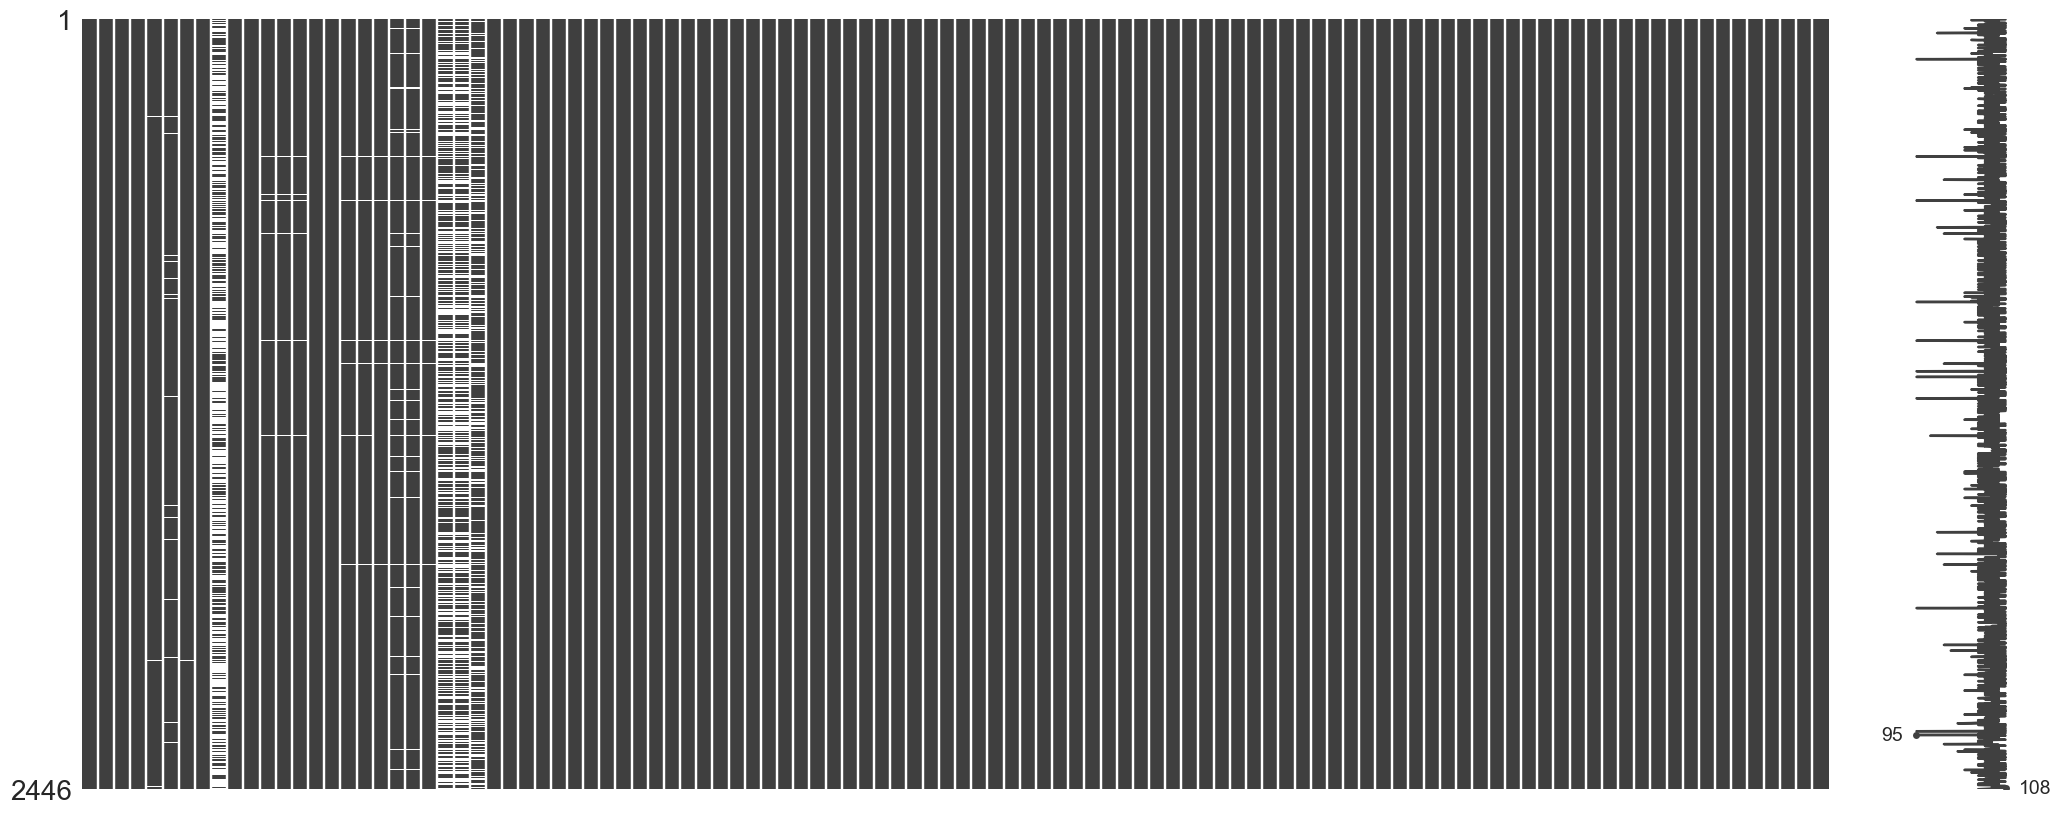

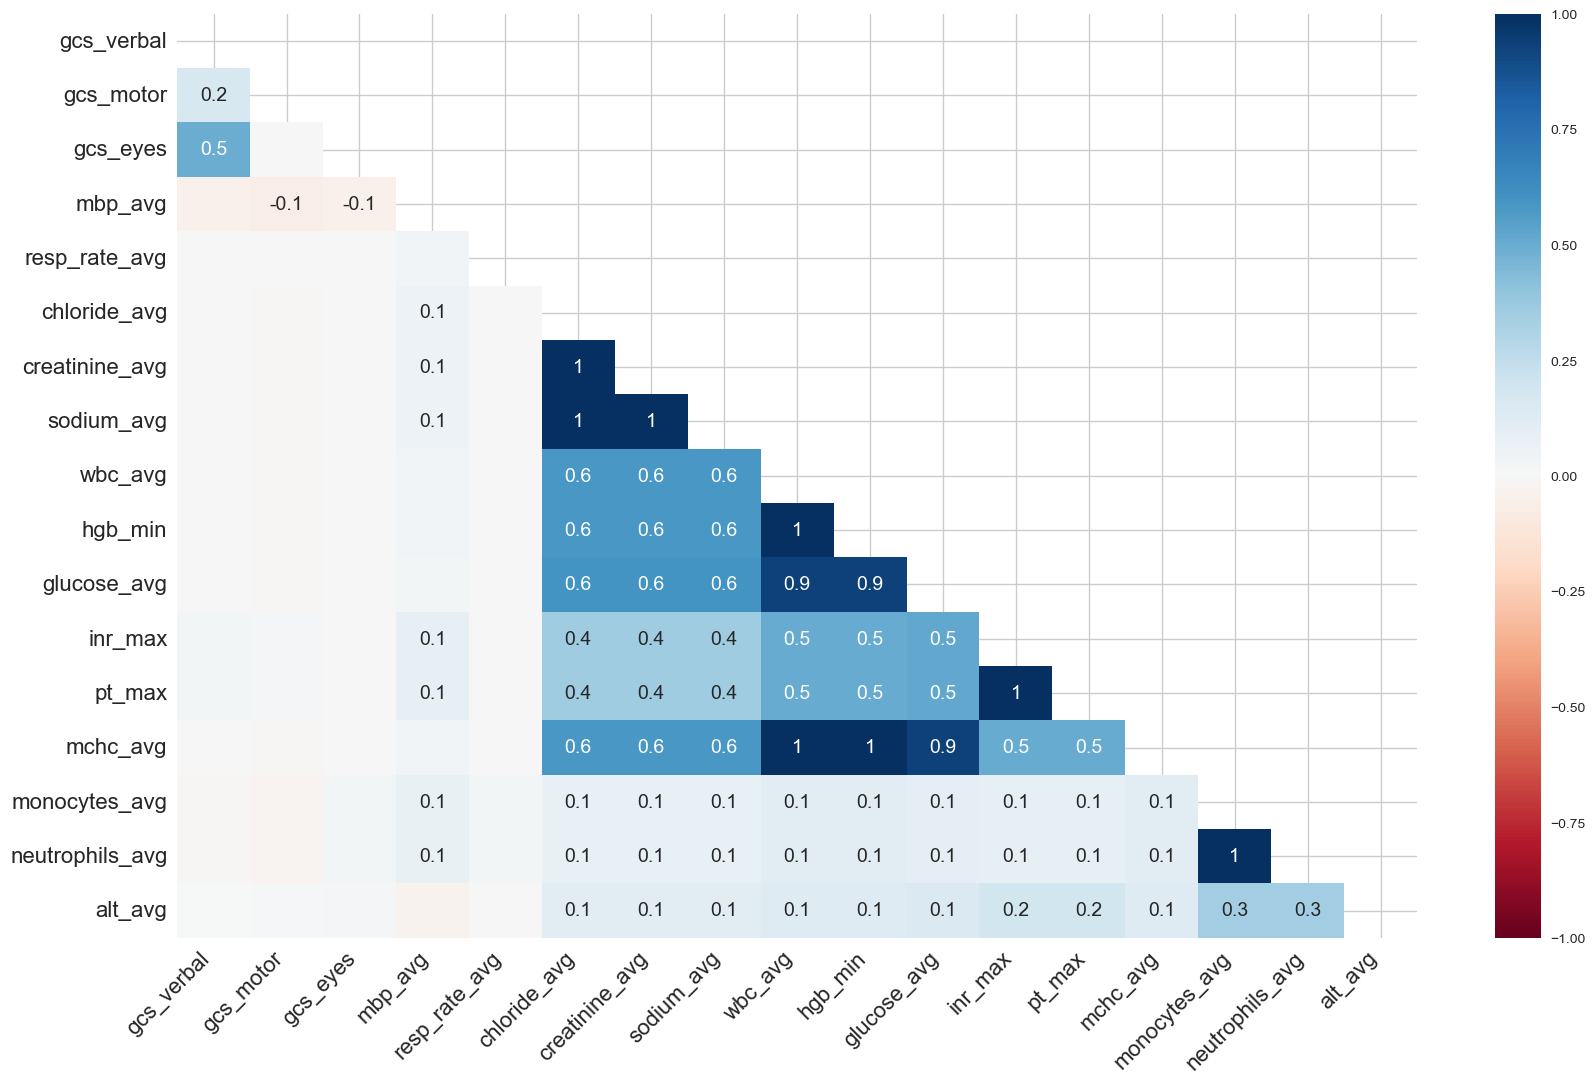

In [105]:
# Visualize missing data patterns

import missingno as msno
msno.matrix(df_clean)  # Busca patrons visuals (ex: columnes amb missings correlacionades)

# Heatmap: correlations of missingness
msno.heatmap(df_clean)

In [106]:
from scipy.stats import chi2_contingency, ttest_ind, ks_2samp

# Loop through numeric variables with missing values
numeric_with_missing = df_clean.select_dtypes(include='number').columns[df_clean.select_dtypes(include='number').isnull().any()]

for col in numeric_with_missing:
    print(f"\n--- Analyzing: {col} ---")
    
    # Create a missingness flag: 1 if missing, 0 if not
    missing_flag = df_clean[col].isnull().astype(int)
    
    # Get readmitted groups
    readmitted_missing = df_clean.loc[missing_flag == 1, 'readmitted'].dropna()
    readmitted_nonmissing = df_clean.loc[missing_flag == 0, 'readmitted'].dropna()
    
    # -- Chi-squared Test
    contingency = pd.crosstab(missing_flag, df_clean['readmitted'])
    if contingency.shape == (2, 2):
        chi2, p_chi, _, _ = chi2_contingency(contingency)
        print(f"Chi-squared p = {p_chi:.4f}", end="  ")
        print("--> " + ("Assoc. detected" if p_chi < 0.05 else "No assoc."))
    
    # -- T-Test
    if len(readmitted_missing) > 10 and len(readmitted_nonmissing) > 10:
        t_stat, p_t = ttest_ind(readmitted_missing, readmitted_nonmissing, equal_var=False)
        print(f"T-test p = {p_t:.4f}", end="  ")
        print("--> " + ("Means differ" if p_t < 0.05 else "No mean diff."))
    
        # -- KS Test
        ks_stat, p_ks = ks_2samp(readmitted_missing, readmitted_nonmissing)
        print(f"KS-test p = {p_ks:.4f}", end="  ")
        print("--> " + ("Distributions differ" if p_ks < 0.05 else "No dist. diff."))


--- Analyzing: mbp_avg ---
Chi-squared p = 0.0000  --> Assoc. detected
T-test p = 0.0000  --> Means differ
KS-test p = 0.0037  --> Distributions differ

--- Analyzing: resp_rate_avg ---
Chi-squared p = 1.0000  --> No assoc.

--- Analyzing: chloride_avg ---
Chi-squared p = 0.2286  --> No assoc.
T-test p = 0.0207  --> Means differ
KS-test p = 0.8408  --> No dist. diff.

--- Analyzing: creatinine_avg ---
Chi-squared p = 0.2286  --> No assoc.
T-test p = 0.0207  --> Means differ
KS-test p = 0.8408  --> No dist. diff.

--- Analyzing: sodium_avg ---
Chi-squared p = 0.2286  --> No assoc.
T-test p = 0.0207  --> Means differ
KS-test p = 0.8408  --> No dist. diff.

--- Analyzing: wbc_avg ---
Chi-squared p = 1.0000  --> No assoc.
T-test p = 0.9605  --> No mean diff.
KS-test p = 1.0000  --> No dist. diff.

--- Analyzing: hgb_min ---
Chi-squared p = 1.0000  --> No assoc.
T-test p = 0.9605  --> No mean diff.
KS-test p = 1.0000  --> No dist. diff.

--- Analyzing: glucose_avg ---
Chi-squared p = 0.819

## Imputación de Valores Faltantes: Estrategia Basada en Análisis MCAR/MAR

Aplicamos diferentes estrategias de imputación según el tipo de ausencia de datos:

- **MCAR (Completamente al Azar)**: No hay evidencia de relación con la variable objetivo (`readmitted`).
- **MAR (Aleatorio Condicional)**: La ausencia muestra cierta correlación con `readmitted`.

Usamos imputación por KNN para tener en cuenta patrones entre variables similares.

Además, para las variables con señales fuertes de MAR/MNAR, añadimos indicadores binarios que marcan si el valor estaba originalmente ausente. Esto permite al modelo capturar información útil sobre la ausencia en sí misma.


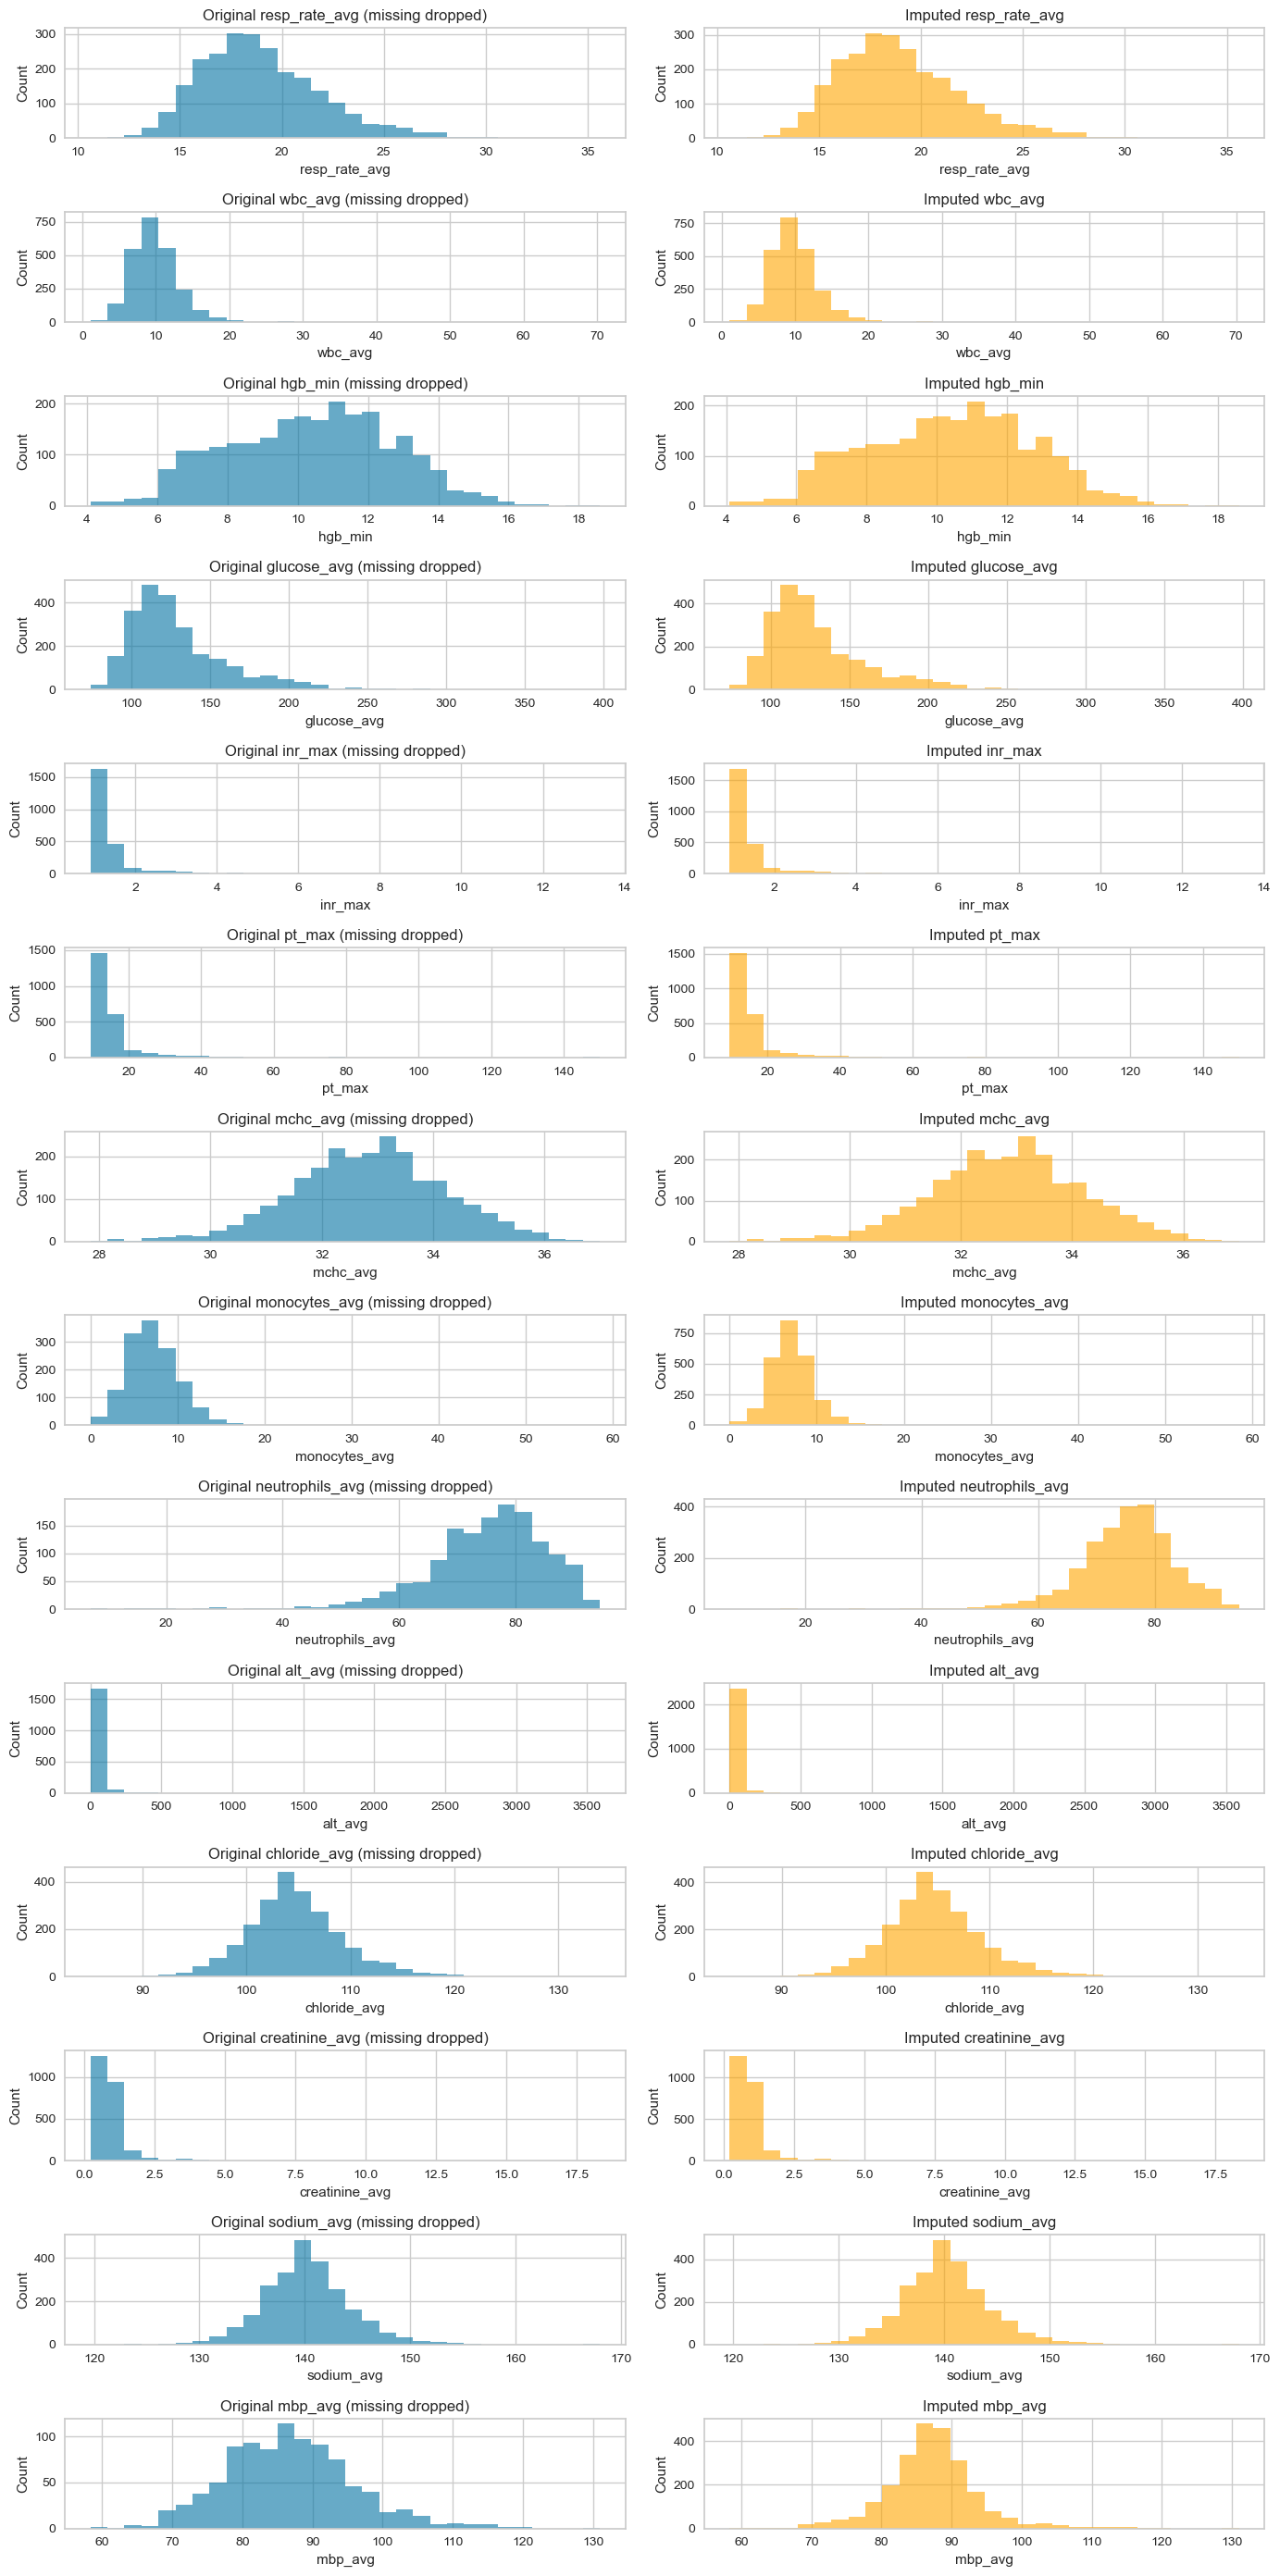

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# --- Step 1: Define variables based on missingness analysis ---
mcar_vars = [
    'resp_rate_avg', 'wbc_avg', 'hgb_min', 'glucose_avg',
    'inr_max', 'pt_max', 'mchc_avg', 'monocytes_avg', 
    'neutrophils_avg', 'alt_avg'
]
weak_mar_vars = ['chloride_avg', 'creatinine_avg', 'sodium_avg']
strong_mar_vars = ['mbp_avg']
all_impute_vars = mcar_vars + weak_mar_vars + strong_mar_vars

# --- Step 2: Save a copy of original data (before imputation) ---
df_original = df_clean.copy()

# --- Step 3: Imputation ---

# 3.1 KNN imputation for all variables
knn_imputer = KNNImputer(n_neighbors=5)
df_clean[all_impute_vars] = knn_imputer.fit_transform(df_clean[all_impute_vars])

# 3.2 Add missingness flags for strong MAR variables
for col in strong_mar_vars:
    df_clean[f'{col}_missing'] = df_original[col].isnull().astype(int)

# --- Step 4: Plot original vs imputed histograms ---
plt.figure(figsize=(14, len(all_impute_vars) * 2))

for i, col in enumerate(all_impute_vars):
    # Original data (only non-missing values)
    plt.subplot(len(all_impute_vars), 2, 2 * i + 1)
    plt.hist(df_original[col].dropna(), bins=30, alpha=0.6, label='Original')
    plt.title(f'Original {col} (missing dropped)')
    plt.ylabel('Count')
    plt.xlabel(col)

    # Imputed data (after imputation)
    plt.subplot(len(all_impute_vars), 2, 2 * i + 2)
    plt.hist(df_clean[col], bins=30, alpha=0.6, color='orange', label='Imputed')
    plt.title(f'Imputed {col}')
    plt.ylabel('Count')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


<Axes: >

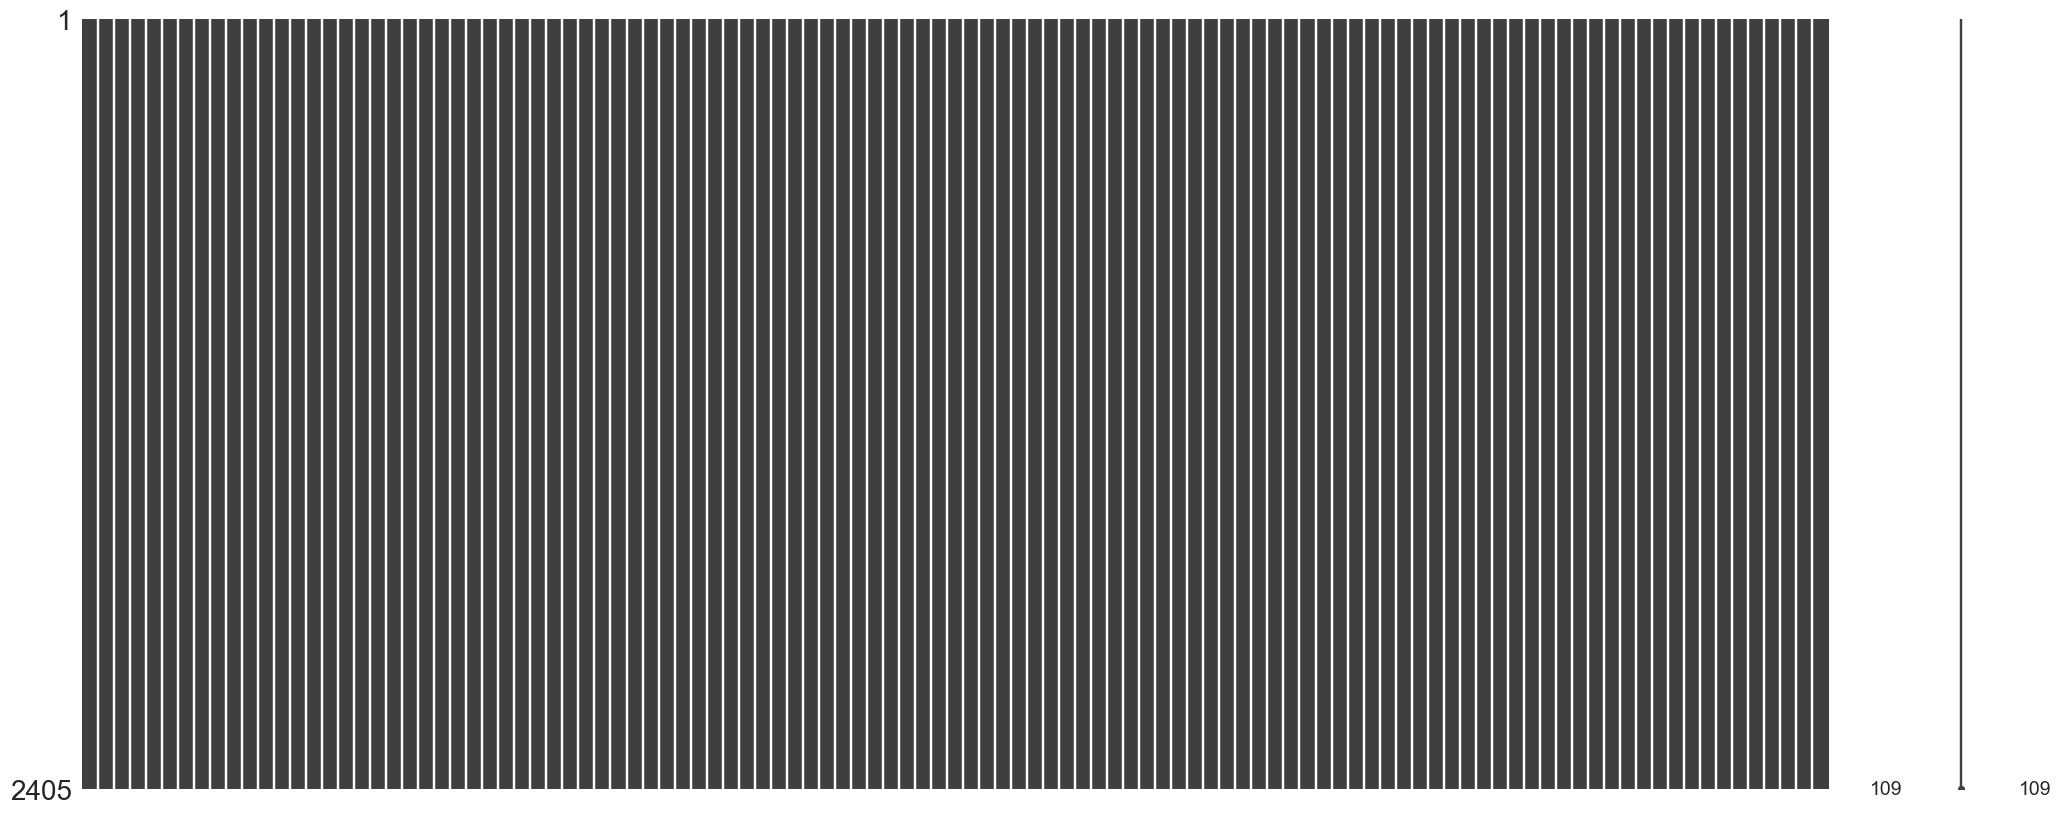

In [108]:
# Visualize missing data patterns

import missingno as msno
df_clean = df_clean.dropna()
msno.matrix(df_clean)  # Busca patrons visuals (ex: columnes amb missings correlacionades)

In [109]:
# Limpiar nombres de columnas antes de pasar a PyCaret
df_clean.columns = (
    df_clean.columns
    .str.strip()
    .str.upper()
    .str.replace('[^A-Z0-9_]', '_', regex=True)  # Reemplaza espacios y símbolos por _
    .str.replace('_+', '_', regex=True)          # Sustituye múltiples _ por uno solo
    .str.strip('_')                              # Elimina guiones bajos sobrantes
)

# Execute Query and Export to CSV
df_clean.to_csv("data/df_clean.csv", index=False)
print("✅ Exported to df_clean.csv")

print(df_clean.dtypes)


df_clean

✅ Exported to df_clean.csv
GENDER                            category
AGE                                  int64
ICU_LOS_HOURS                      float64
HOSP_LOS_HOURS                       int64
GCS_VERBAL                        category
                                    ...   
DISPO_HOSPICE                        int64
DISPO_OTHER_FACILITY                 int64
DISPO_REHAB                          int64
DISPO_SKILLED_NURSING_FACILITY       int64
MBP_AVG_MISSING                      int64
Length: 109, dtype: object


,GENDER,AGE,ICU_LOS_HOURS,HOSP_LOS_HOURS,GCS_VERBAL,GCS_MOTOR,GCS_EYES,HEART_RATE_AVG,MBP_AVG,RESP_RATE_AVG,...,DISPO_ASSISTED_LIVING,DISPO_CHRONIC_LONG_TERM_ACUTE_CARE,DISPO_HEALTHCARE_FACILITY,DISPO_HOME,DISPO_HOME_HEALTH_CARE,DISPO_HOSPICE,DISPO_OTHER_FACILITY,DISPO_REHAB,DISPO_SKILLED_NURSING_FACILITY,MBP_AVG_MISSING
4,M,49,377.0,1165,0.0,1.0,1.0,82.062663,80.974093,22.049869,...,0,0,0,0,0,0,0,1,0,0
5,F,71,188.0,237,4.0,6.0,4.0,85.320225,86.720588,17.422857,...,0,0,0,0,0,0,0,1,0,0
7,M,63,137.0,139,0.0,4.0,2.0,80.830769,84.946154,15.125000,...,0,1,0,0,0,0,0,0,0,1
10,M,78,38.0,107,3.0,6.0,4.0,58.750000,87.863567,20.800000,...,0,0,0,0,0,0,0,0,1,1
13,F,91,230.0,281,4.0,6.0,3.0,80.233161,92.181600,20.616580,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,F,65,31.0,296,0.0,1.0,1.0,92.844444,76.878049,14.000000,...,0,0,0,0,0,0,0,0,1,0
3616,M,50,829.0,853,5.0,6.0,4.0,85.173238,83.085399,14.939502,...,0,0,0,0,0,0,0,1,0,0
3617,M,62,48.0,261,4.0,6.0,4.0,68.185185,84.521739,15.622642,...,0,0,0,1,0,0,0,0,0,0
3619,M,69,40.0,166,4.0,6.0,4.0,73.275000,88.728903,15.400000,...,0,0,0,0,1,0,0,0,0,1


## 4. 📊 Modelado Predictivo

In [6]:
from pycaret.classification import *
import pandas as pd
import numpy as np

df= pd.read_csv("data/df_clean.csv")
print(f"✅ Archivo cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

exp = setup(
    data=df,
    target='READMITTED',
    session_id=123,
    normalize=True,  # solo si incluirás modelos que lo requieren
    #feature_selection=True,  # <-- activa selección de variables
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()

df

✅ Archivo cargado: 2405 filas, 109 columnas


,Description,Value
0,Session id,123
1,Target,READMITTED
2,Target type,Binary
3,Original data shape,"(2405, 109)"
4,Transformed data shape,"(2405, 109)"
5,Transformed train set shape,"(1683, 109)"
6,Transformed test set shape,"(722, 109)"
7,Numeric features,107
8,Categorical features,1
9,Preprocess,True



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8301,0.6668,0.1204,0.7833,0.2053,0.1658,0.2595,0.0560
rf,Random Forest Classifier,0.8235,0.6613,0.0571,0.8667,0.1060,0.0874,0.1949,0.0660
ridge,Ridge Classifier,0.8194,0.6306,0.0954,0.5532,0.1603,0.1174,0.1767,0.0200
dummy,Dummy Classifier,0.8134,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0220
lightgbm,Light Gradient Boosting Machine,0.8093,0.6686,0.1048,0.4724,0.1695,0.1075,0.1488,0.2530
gbc,Gradient Boosting Classifier,0.8087,0.6588,0.0700,0.4733,0.1191,0.0706,0.1135,0.1550
lr,Logistic Regression,0.8069,0.6303,0.1211,0.4472,0.1864,0.1169,0.1505,0.0330
lda,Linear Discriminant Analysis,0.8069,0.6306,0.1273,0.4580,0.1920,0.1218,0.1558,0.0250
knn,K Neighbors Classifier,0.8021,0.5765,0.0828,0.3386,0.1318,0.0696,0.0899,0.0190
ada,Ada Boost Classifier,0.7974,0.6639,0.1244,0.3874,0.1843,0.1021,0.1259,0.0510


,GENDER,AGE,ICU_LOS_HOURS,HOSP_LOS_HOURS,GCS_VERBAL,GCS_MOTOR,GCS_EYES,HEART_RATE_AVG,MBP_AVG,RESP_RATE_AVG,...,DISPO_ASSISTED_LIVING,DISPO_CHRONIC_LONG_TERM_ACUTE_CARE,DISPO_HEALTHCARE_FACILITY,DISPO_HOME,DISPO_HOME_HEALTH_CARE,DISPO_HOSPICE,DISPO_OTHER_FACILITY,DISPO_REHAB,DISPO_SKILLED_NURSING_FACILITY,MBP_AVG_MISSING
0,M,49,377.0,1165,0.0,1.0,1.0,82.062663,80.974093,22.049869,...,0,0,0,0,0,0,0,1,0,0
1,F,71,188.0,237,4.0,6.0,4.0,85.320225,86.720588,17.422857,...,0,0,0,0,0,0,0,1,0,0
2,M,63,137.0,139,0.0,4.0,2.0,80.830769,84.946154,15.125000,...,0,1,0,0,0,0,0,0,0,1
3,M,78,38.0,107,3.0,6.0,4.0,58.750000,87.863567,20.800000,...,0,0,0,0,0,0,0,0,1,1
4,F,91,230.0,281,4.0,6.0,3.0,80.233161,92.181600,20.616580,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400,F,65,31.0,296,0.0,1.0,1.0,92.844444,76.878049,14.000000,...,0,0,0,0,0,0,0,0,1,0
2401,M,50,829.0,853,5.0,6.0,4.0,85.173238,83.085399,14.939502,...,0,0,0,0,0,0,0,1,0,0
2402,M,62,48.0,261,4.0,6.0,4.0,68.185185,84.521739,15.622642,...,0,0,0,1,0,0,0,0,0,0
2403,M,69,40.0,166,4.0,6.0,4.0,73.275000,88.728903,15.400000,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
et_model = create_model('et')
evaluate_model(et_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8225,0.6162,0.1562,0.6250,0.2500,0.1885,0.2479
1,0.8462,0.6836,0.1875,1.0000,0.3158,0.2723,0.3970
2,0.8462,0.7479,0.2188,0.8750,0.3500,0.2967,0.3901
3,0.8095,0.6463,0.0323,0.3333,0.0588,0.0271,0.0517
4,0.8095,0.5784,0.0323,0.3333,0.0588,0.0271,0.0517
5,0.8333,0.6440,0.0968,1.0000,0.1765,0.1488,0.2835
6,0.8333,0.7000,0.0968,1.0000,0.1765,0.1488,0.2835
7,0.8274,0.6580,0.1290,0.6667,0.2162,0.1663,0.2392
8,0.8393,0.6432,0.1290,1.0000,0.2286,0.1946,0.3283


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
rf_model = create_model('rf')
evaluate_model(rf_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8166,0.6167,0.0625,0.6667,0.1143,0.0846,0.1638
1,0.8284,0.7134,0.0938,1.0000,0.1714,0.1436,0.2782
2,0.8284,0.7687,0.0938,1.0000,0.1714,0.1436,0.2782
3,0.8214,0.5786,0.0323,1.0000,0.0625,0.0516,0.1627
4,0.8155,0.5666,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.8214,0.6442,0.0323,1.0000,0.0625,0.0516,0.1627
6,0.8214,0.6890,0.0323,1.0000,0.0625,0.0516,0.1627
7,0.8333,0.6108,0.0968,1.0000,0.1765,0.1488,0.2835
8,0.8274,0.6655,0.0645,1.0000,0.1212,0.1011,0.2307


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [10]:
predictions = predict_model(et_model)  # uses internal X_test
print(et_model.classes_)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8435,0.6730,0.1866,0.8621,0.3067,0.2577,0.3559


[0 1]


In [15]:
predictions['score'] = predictions['prediction_score']
print(predictions[['READMITTED', 'prediction_label', 'score']].head(10))
print(predictions[predictions['prediction_label'] == 1][['READMITTED', 'prediction_label', 'score']].head(20))

print(predictions[predictions['score'] > 0.8][['READMITTED', 'prediction_label', 'score']].head(20))

      READMITTED  prediction_label  score
932            0                 0   0.85
1542           1                 0   0.72
1630           0                 0   0.81
585            0                 1   0.53
2039           0                 0   0.73
1512           0                 0   0.74
1956           0                 0   0.79
1885           0                 0   0.96
1613           0                 0   0.89
871            0                 0   0.92
      READMITTED  prediction_label  score
585            0                 1   0.53
1429           1                 1   0.53
1738           1                 1   0.80
2295           1                 1   0.72
594            1                 1   0.91
933            0                 1   0.51
986            1                 1   0.54
730            1                 1   0.81
1377           1                 1   0.56
345            1                 1   0.94
1689           1                 1   0.73
1507           0                 1

In [165]:
# Paso 8: Guardar y Cargar el Modelo
print("\nGuardando el modelo...")
save_model(et_model, 'readmission-risk-app/model/modelo_et_1')

# Cargar el modelo guardado
print("\nCargando el modelo guardado...")
loaded_model = load_model('readmission-risk-app/model/modelo_et_1')


Guardando el modelo...
Transformation Pipeline and Model Successfully Saved

Cargando el modelo guardado...
Transformation Pipeline and Model Successfully Loaded


In [3]:
from pycaret.classification import *
import pandas as pd
import numpy as np

df_clean= pd.read_csv("data/df_clean.csv")
print(f"✅ Archivo cargado: {df_clean.shape[0]} filas, {df_clean.shape[1]} columnas")

exp = setup(
    data=df_clean,
    target='READMITTED',
    session_id=123,
    normalize=True,  # solo si incluirás modelos que lo requieren
    feature_selection=True,  # <-- activa selección de variables
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model_fs = compare_models()

✅ Archivo cargado: 2405 filas, 109 columnas


,Description,Value
0,Session id,123
1,Target,READMITTED
2,Target type,Binary
3,Original data shape,"(2405, 109)"
4,Transformed data shape,"(2405, 22)"
5,Transformed train set shape,"(1683, 22)"
6,Transformed test set shape,"(722, 22)"
7,Numeric features,107
8,Categorical features,1
9,Preprocess,True



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8217,0.6644,0.0539,0.9100,0.1002,0.0804,0.1886,0.3050
rf,Random Forest Classifier,0.8146,0.6453,0.0256,0.5500,0.0487,0.0335,0.0891,0.3350
dummy,Dummy Classifier,0.8134,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2820
ridge,Ridge Classifier,0.8122,0.6040,0.0031,0.1000,0.0061,0.0015,0.0049,0.2690
lr,Logistic Regression,0.8093,0.6056,0.0095,0.2500,0.0182,0.0036,0.0187,0.5440
lda,Linear Discriminant Analysis,0.8087,0.6039,0.0126,0.2333,0.0237,0.0062,0.0206,0.2890
lightgbm,Light Gradient Boosting Machine,0.8021,0.6012,0.0606,0.3593,0.1022,0.0481,0.0750,0.4700
knn,K Neighbors Classifier,0.8009,0.5810,0.0827,0.3568,0.1299,0.0669,0.0896,0.2820
gbc,Gradient Boosting Classifier,0.7992,0.5825,0.0255,0.1986,0.0445,0.0034,0.0083,0.4240
ada,Ada Boost Classifier,0.7944,0.6017,0.0670,0.2853,0.1062,0.0396,0.0533,0.2930


In [4]:
et_model = create_model('et')
evaluate_model(et_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8166,0.6193,0.0938,0.6000,0.1622,0.1170,0.1830
1,0.8284,0.7351,0.0938,1.0000,0.1714,0.1436,0.2782
2,0.8225,0.7534,0.0625,1.0000,0.1176,0.0975,0.2264
3,0.8274,0.5637,0.0645,1.0000,0.1212,0.1011,0.2307
4,0.8214,0.6011,0.0323,1.0000,0.0625,0.0516,0.1627
5,0.8214,0.6857,0.0323,1.0000,0.0625,0.0516,0.1627
6,0.8214,0.6755,0.0323,1.0000,0.0625,0.0516,0.1627
7,0.8274,0.5978,0.0645,1.0000,0.1212,0.1011,0.2307
8,0.8155,0.7332,0.0323,0.5000,0.0606,0.0391,0.0893


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [123]:
exp_smote = setup(
    data=df_clean,
    target='READMITTED',
    session_id=123,
    normalize=True,
    #feature_selection=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    fix_imbalance=True,  # 🔥 esto activa balanceo de clases
    fix_imbalance_method='smote',  # (opcional) puedes usar otras como 'adasyn'
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model_smote = compare_models()

,Description,Value
0,Session id,123
1,Target,READMITTED
2,Target type,Binary
3,Original data shape,"(2405, 109)"
4,Transformed data shape,"(3460, 109)"
5,Transformed train set shape,"(2738, 109)"
6,Transformed test set shape,"(722, 109)"
7,Numeric features,107
8,Categorical features,1
9,Preprocess,True



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8277,0.6789,0.1462,0.7032,0.2372,0.1849,0.2598,0.0840
rf,Random Forest Classifier,0.8223,0.6557,0.1047,0.6417,0.1767,0.1334,0.2035,0.1030
dummy,Dummy Classifier,0.8134,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0300
gbc,Gradient Boosting Classifier,0.8099,0.6495,0.0923,0.4734,0.1522,0.0961,0.1392,0.3330
lightgbm,Light Gradient Boosting Machine,0.8087,0.6535,0.1302,0.4343,0.1965,0.1269,0.1558,0.3160
ada,Ada Boost Classifier,0.7689,0.6077,0.1401,0.2792,0.1823,0.0659,0.0728,0.1020
dt,Decision Tree Classifier,0.6952,0.5340,0.2769,0.2341,0.2530,0.0640,0.0643,0.0410
lr,Logistic Regression,0.6328,0.6281,0.5038,0.2542,0.3367,0.1194,0.1341,0.0440
lda,Linear Discriminant Analysis,0.6298,0.6349,0.5228,0.2573,0.3434,0.1258,0.1427,0.0370
ridge,Ridge Classifier,0.6292,0.6349,0.5228,0.2569,0.3430,0.1252,0.1421,0.0390


In [ ]:
et_model = create_model('et')
evaluate_model(et_model)

import joblib
joblib.dump(model, "readmission_model.pkl")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8047,0.6421,0.1562,0.4545,0.2326,0.1502,0.1786
1,0.8343,0.7118,0.1875,0.7500,0.3000,0.2426,0.3190
2,0.8402,0.7351,0.2500,0.7273,0.3721,0.3047,0.3623
3,0.8155,0.6923,0.0645,0.5000,0.1143,0.0753,0.1270
4,0.8095,0.5798,0.0968,0.4286,0.1579,0.0965,0.1312
5,0.8452,0.6664,0.1613,1.0000,0.2778,0.2388,0.3682
6,0.8214,0.6463,0.0968,0.6000,0.1667,0.1216,0.1876
7,0.8333,0.6528,0.1613,0.7143,0.2632,0.2094,0.2848
8,0.8452,0.6648,0.1935,0.8571,0.3158,0.2659,0.3616


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [125]:
exp_smote = setup(
    data=df_clean,
    target='READMITTED',
    session_id=123,
    normalize=True,
    feature_selection=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    fix_imbalance=True,  # 🔥 esto activa balanceo de clases
    fix_imbalance_method='smote',  # (opcional) puedes usar otras como 'adasyn'
)

# Comparar modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model_smote_fs = compare_models()

[LightGBM] [Info] Number of positive: 1369, number of negative: 1369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10635
[LightGBM] [Info] Number of data points in the train set: 2738, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Description,Value
0,Session id,123
1,Target,READMITTED
2,Target type,Binary
3,Original data shape,"(2405, 109)"
4,Transformed data shape,"(3460, 22)"
5,Transformed train set shape,"(2738, 22)"
6,Transformed test set shape,"(722, 22)"
7,Numeric features,107
8,Categorical features,1
9,Preprocess,True



Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.8134,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3370
et,Extra Trees Classifier,0.7843,0.6386,0.1686,0.3509,0.2240,0.1166,0.1289,0.4690
lightgbm,Light Gradient Boosting Machine,0.7611,0.5918,0.1749,0.2824,0.2140,0.0830,0.0870,0.5380
rf,Random Forest Classifier,0.7582,0.6224,0.1876,0.2892,0.2265,0.0903,0.0942,0.4310
gbc,Gradient Boosting Classifier,0.6958,0.5880,0.3058,0.2469,0.2717,0.0833,0.0844,0.5420
dt,Decision Tree Classifier,0.6851,0.5451,0.3218,0.2410,0.2747,0.0793,0.0810,0.3380
ada,Ada Boost Classifier,0.6572,0.5975,0.4080,0.2526,0.3088,0.1009,0.1062,0.3750
lr,Logistic Regression,0.5858,0.5980,0.4967,0.2229,0.3066,0.0683,0.0813,0.3400
ridge,Ridge Classifier,0.5852,0.6016,0.4998,0.2239,0.3081,0.0697,0.0828,0.3460
lda,Linear Discriminant Analysis,0.5852,0.6016,0.4998,0.2239,0.3081,0.0697,0.0828,0.3710


In [118]:
tuned_model = tune_model(best_model, optimize='AUC')  # or accuracy, recall, etc.

evaluate_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5562,0.5839,0.5312,0.2208,0.3119,0.0606,0.0734
1,0.6331,0.6777,0.6875,0.2973,0.4151,0.2049,0.2432
2,0.5917,0.6544,0.6250,0.2597,0.3670,0.1358,0.1644
3,0.5893,0.6047,0.4839,0.2206,0.3030,0.0664,0.0767
4,0.5833,0.5592,0.5161,0.2254,0.3137,0.0765,0.0900
5,0.6071,0.6593,0.7419,0.2840,0.4107,0.1962,0.2473
6,0.6012,0.6327,0.6129,0.2568,0.3619,0.1376,0.1652
7,0.5774,0.6051,0.5161,0.2222,0.3107,0.0710,0.0842
8,0.5952,0.6953,0.6774,0.2658,0.3818,0.1589,0.1975


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…